In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from demo import TransformableBasinCMAProjection
import os, cv2, numpy as np
import matplotlib.pyplot as plt
from im_utils import to_image, make_grid, center_crop, smart_resize
import torch

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="2"

### First initialize the optimizer

This demo code abstracts away all the knitty gritty stuff.

In [6]:
demo_solver = TransformableBasinCMAProjection()

### Load image
Here we will use an example of a border-collie dog image. For simplicity we center crop and resize the image to be in the correct resolution for the generative model.   
You could also consider running automatic-detection first and then resize it accordingly to get that extra-crispy resolution.

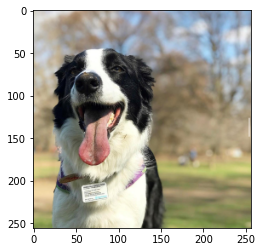

In [7]:
im = cv2.imread('./examples/very-cute-doggo.jpg')[:, :, [2, 1, 0]] 
im = smart_resize(center_crop(im))

plt.figure()
plt.imshow(im)

### Automatically Detecting Class and Mask
<b>"I don't have the mask and I don't know the image class"</b>  
If you don't know the exact class and the object outline, we can use ResNext101 to predict the class and use Mask-RCNN to find the appropriate mask  

<b>"I got this, im an expert"</b>   
If you have the mask image and you know the class you can skip this part.

In [14]:
# NOTE: The auto_detection will cache the mask and class in the solver! 
# If auto_detection fails .. loss is computed on the whole image. 
# This will make Transformation search not very effective.
# You can mitigate this by providing the mask and label manually :(

## To use Segmenation Mask 
#mask = demo_solver.auto_detect(im, mask_type='mask')

## To use Bounding Box (bbox was used in the paper)
mask = demo_solver.auto_detect(im, mask_type='bbox')[0]

Found a match. Classified class Border collie is in the detected class dog


### Check if the automatic detection worked as we wanted

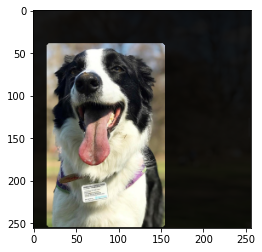

In [15]:
plt.figure()
plt.imshow((im / 255.) * mask.clip(0.1, 1.0));

### Lets optimize
The optimization code uses:   
<b> 
    encoder warm-up,   
    alexnet-lpips,   
    spatial + color transformation,   
    basin-cma  
</b>

It will first search for the transformation parameters and then use BasinCMA to optimize for the latent variable.   
This should take roughly 5-10 minutes to optimize. Yikes! thats a little slow. What's causing it be slow?

1. The forward and backward pass of the generative model. BigGANs are extremely huge.
2. Perceptual loss

Finding out how to speed these up might be an interesting research direction for "real-time" image projections.

Check out `demo.py` if you want to play around with the optimization setting. 

In [16]:
variables, outs, losses, transform_fn = demo_solver(im, log=False)
# variables, outs, losses, transform_fn = demo_solver(im, log=False, cma_steps=10, adam_steps=10, finetune_steps=50, transform_cma_steps=1, transform_adam_steps=1, encoder_init=True)

# If you dont have all day .. try optimizing with these parameters
#variables, outs, losses, transform_fn = demo_solver(im, log=False, cma_steps=10, adam_steps=10, finetune_steps=300, transform_cma_steps=10, transform_adam_steps=10, encoder_init=True)

## If you know the class label and have the mask image (HW1), you can pass it into the solver. 
#variables, outs, losses, transform_fn = demo_solver(im, cls_lbl=232, mask=np.ones_like(im)[:, :, :1], log=False)

Found class label from auto_detect()
Found mask from auto_detect()
Searching for transformation
(transform) progress 6% [50/900] 
(transform) progress 11% [100/900] 
(transform) progress 17% [150/900] 
(transform) progress 22% [200/900] 
(transform) progress 28% [250/900] 
(transform) progress 33% [300/900] 
(transform) progress 39% [350/900] 
(transform) progress 44% [400/900] 
(transform) progress 50% [450/900] 
(transform) progress 56% [500/900] 
(transform) progress 61% [550/900] 
(transform) progress 67% [600/900] 
(transform) progress 72% [650/900] 
(transform) progress 78% [700/900] 
(transform) progress 83% [750/900] 
(transform) progress 89% [800/900] 
(transform) progress 94% [850/900] 
(transform) progress 100% [900/900] 
Warm starting with an Encoder
(9_w,18)-aCMA-ES (mu_w=5.4,w_1=30%) in dimension 128 (seed=<module 'time' (built-in)>, Sun May  3 19:50:12 2020)
(optimize) progress 8% [50/600] 
(optimize) progress 17% [100/600] 
(optimize) progress 25% [150/600] 
(optimize) 

### Let's see how it turned out
Not cute as the original .. but close enough. We will have to wait for the next BigBigGAN-deepdeep.

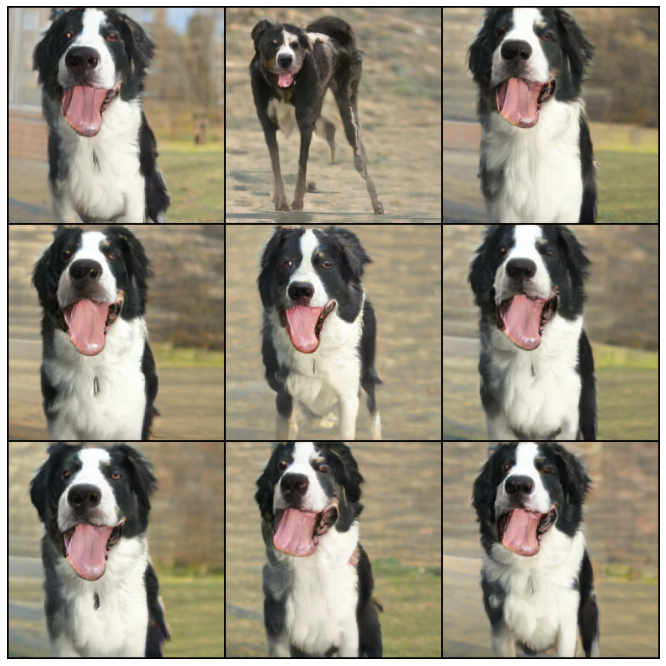

In [17]:
plt.figure(figsize=(12, 12))
plt.imshow(to_image(make_grid(outs), cv2_format=False))
plt.axis('off');

### Accessing the optimized variables
All variables are wrapped as a variable object. To understand the inner workings of this check out `variable_manager.py`  
TLDR; it's just a nested easydict dictionary object. Lets go through some of it.

In [18]:
# Lets see whats inside
print(variables.keys())

dict_keys(['z', 'cv', 'target', 'weight', 't', 'opt', 'num_seeds'])


In [19]:
# Each variable are nested with more stuff
print(variables.z.keys())

# Here are the optimized latent variable + class embedding
z = torch.stack(variables.z.data)
cv = torch.stack(variables.cv.data)

print(z.size(), cv.size())

dict_keys(['data', 'lr', 'requires_grad'])
torch.Size([9, 128]) torch.Size([9, 128])


In [20]:
print(losses)

[4.140233, 6.0741134, 4.3319664, 4.070142, 4.603876, 4.143374, 4.473785, 4.5191193, 4.1332626]


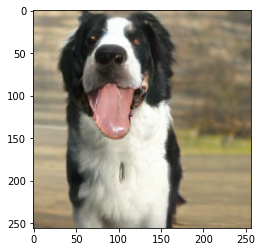

In [21]:
# Lets generate the first example again
idx = np.argmin(losses).squeeze()

with torch.no_grad():
    out = demo_solver.model(z=z[idx:idx+1], c=cv[idx:idx+1])
    out_im = to_image(out, cv2_format=False)[0]
    
plt.figure()
plt.imshow(out_im)

In [22]:
# What was the transformation that was applied?
t = torch.stack(variables.t.data)[idx:idx+1] 
print(t[0])

tensor([ 0.8838, -0.1810,  0.2167,  1.0188], device='cuda:0')


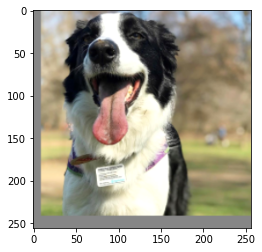

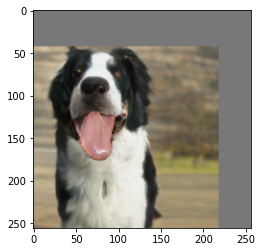

In [23]:
# We can transform the target to see what the model was trying to optimize
transformed_target = to_image(transform_fn(torch.stack(variables.target.data).cpu(), t.cpu()), cv2_format=False)[0]

plt.figure()
plt.imshow(transformed_target)

# Or ... we can invert the image back into the original location and color
inv_im = to_image(transform_fn(out.cpu(), t.cpu(), invert=True), cv2_format=False)[0]

plt.figure()
plt.imshow(inv_im)

### Poisson blending the result

In [24]:
from im_utils import poisson_blend
blended = poisson_blend(im, mask, inv_im)

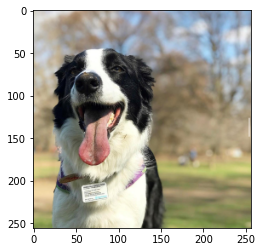

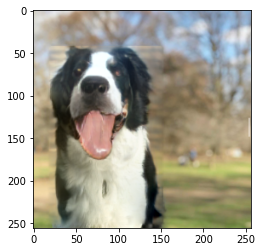

In [26]:
plt.figure()
plt.imshow(im)

plt.figure()
plt.imshow(blended)